In [84]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('capacitor_discharging.csv')
df_charging = pd.read_csv('capacitor_charging.csv')

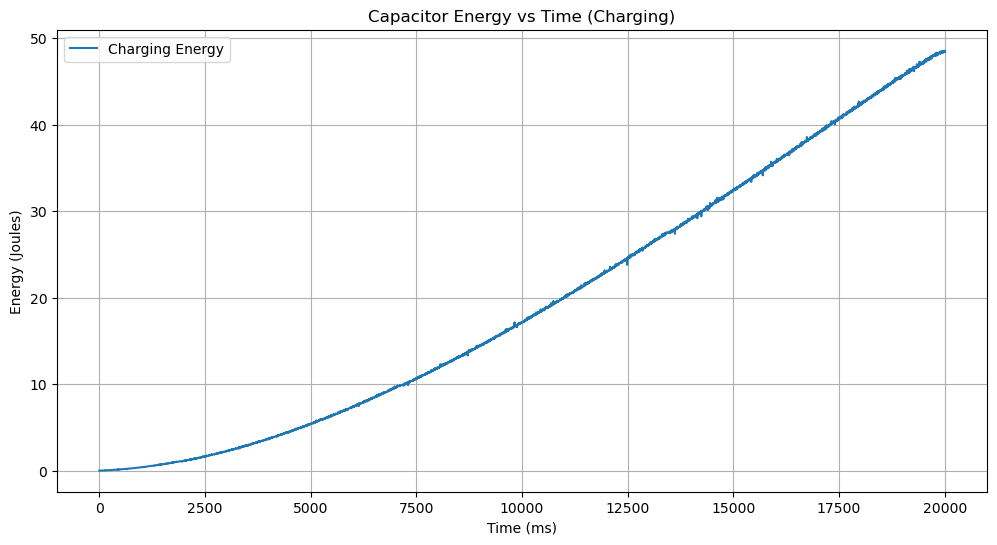

In [88]:
df_charging_clean = df_charging[df_charging.columns[0]].str.split('\t', expand=True)
df_charging_clean.columns = ['time_ms', 'voltage_Va', 'voltage_Vb', 'current_A', 'power_W']
df_charging_clean = df_charging_clean.apply(pd.to_numeric)

df_charging_clean['energy_Vb'] = 0.25 * df_charging_clean['voltage_Vb']**2

plt.figure(figsize=(12, 6))
plt.plot(df_charging_clean['time_ms'], df_charging_clean['energy_Vb'], label='Charging Energy')
plt.xlabel('Time (ms)')
plt.ylabel('Energy (Joules)')
plt.title('Capacitor Energy vs Time (Charging)')
plt.legend()
plt.grid(True)
plt.show()

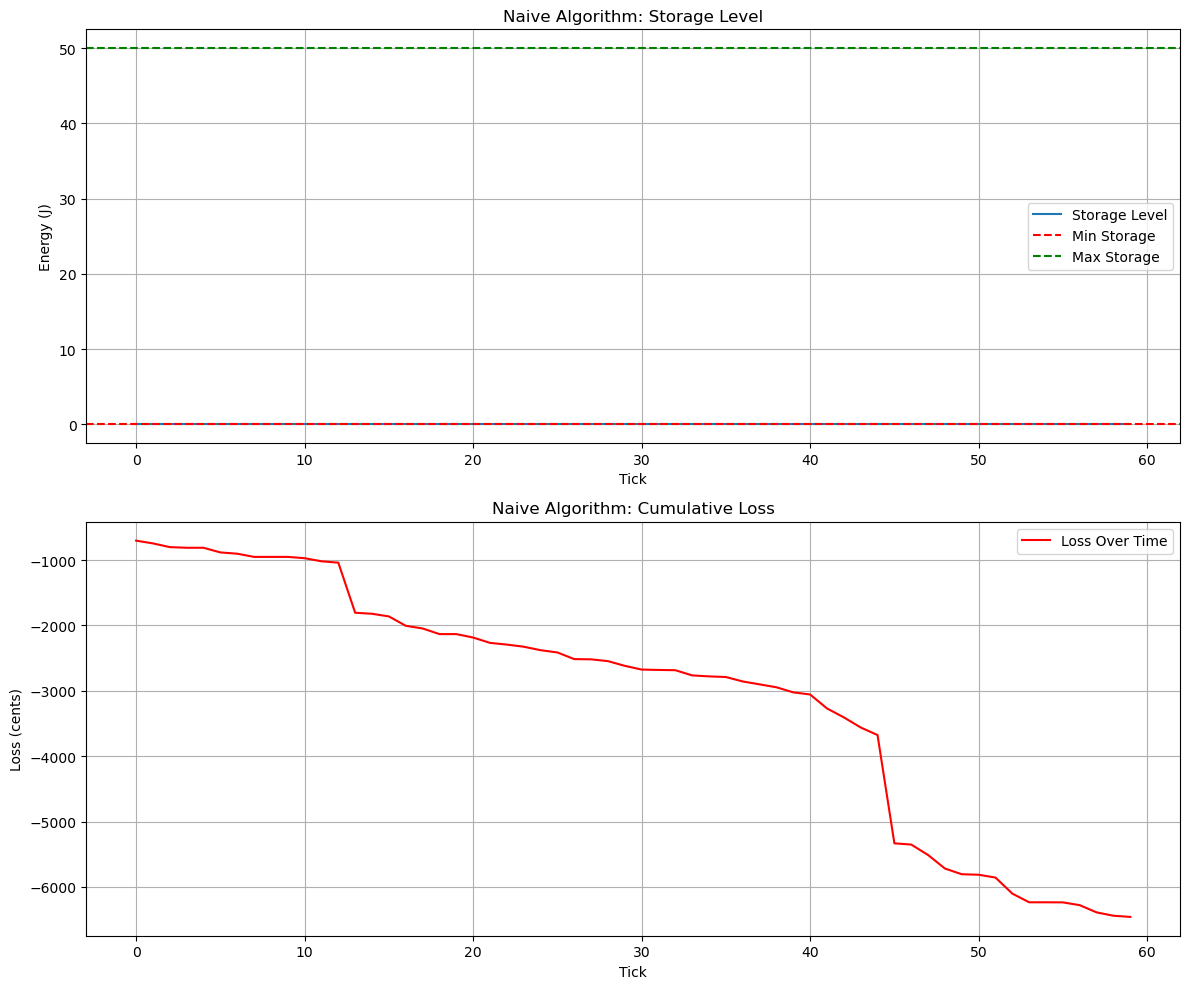

Final loss from naive algorithm: 6459.74 cents
Number of buy actions: 58


In [93]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

BASE_URL = "https://icelec50015.azurewebsites.net"
ENDPOINTS = {
    "yesterday": "/yesterday",
    "deferables": "/deferables"
}
MIN_STORAGE = 0
MAX_STORAGE = 50

def fetch_server_data():
    yesterday_response = requests.get(BASE_URL + ENDPOINTS["yesterday"])
    df = pd.DataFrame(yesterday_response.json())
    
    defer_response = requests.get(BASE_URL + ENDPOINTS["deferables"])
    defer_df = pd.DataFrame(defer_response.json())
    
    return df, defer_df

def run_naive_algorithm(df, defer_df):
    """Naive algorithm - satisfies demands as they come"""
    storage = [0]
    profit = 0
    profit_over_time = []
    actions = []
    
    for tick in range(len(df)):
        current_storage = storage[-1]
        sell_price = df.iloc[tick]['sell_price']
        buy_price = sell_price * 0.5
        instant_demand = df.iloc[tick]['demand']
        
        if instant_demand > 0:
            profit -= instant_demand * buy_price
            actions.append('buy_for_demand')
            
        active_deferables = defer_df[defer_df['start'] == tick]
        for _, demand in active_deferables.iterrows():
            profit -= demand['energy'] * buy_price
            actions.append('buy_for_deferable')
            
        storage.append(current_storage)
        profit_over_time.append(profit)
    
    return storage[1:], profit_over_time, actions

df, defer_df = fetch_server_data()
storage, profit_over_time, actions = run_naive_algorithm(df, defer_df)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.plot(storage, label='Storage Level')
ax1.axhline(y=MIN_STORAGE, color='r', linestyle='--', label='Min Storage')
ax1.axhline(y=MAX_STORAGE, color='g', linestyle='--', label='Max Storage')
ax1.set_title('Naive Algorithm: Storage Level')
ax1.set_xlabel('Tick')
ax1.set_ylabel('Energy (J)')
ax1.legend()
ax1.grid(True)

ax2.plot(profit_over_time, color='red', label='Loss Over Time')
ax2.set_title('Naive Algorithm: Cumulative Loss')
ax2.set_xlabel('Tick')
ax2.set_ylabel('Loss (cents)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Final loss from naive algorithm: {-profit_over_time[-1]:.2f} cents")
print(f"Number of buy actions: {actions.count('buy_for_demand') + actions.count('buy_for_deferable')}")

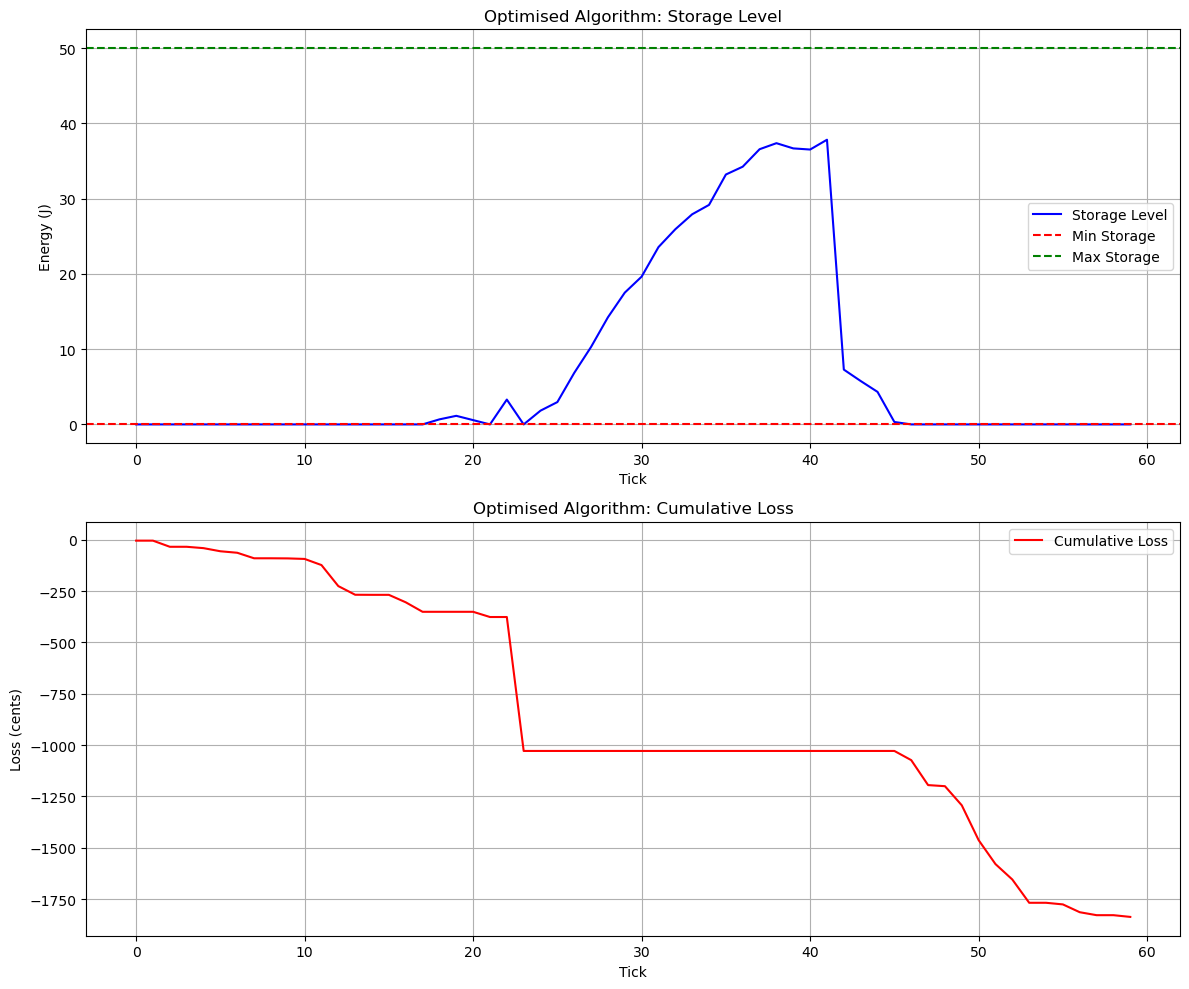

Final loss: 1836.96 cents

Actions breakdown:
- used_storage: 33
- import: 27
- import_for_deferable: 2
- used_storage_for_deferable: 1
- solar_charging: 29


In [91]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

SUNRISE = 15
DAY_LENGTH = 30
MIN_STORAGE = 0
MAX_STORAGE = 50

def add_sun_data(df):
    """Add sun data to dataframe"""
    sun_values = []
    for tick in df['tick']:
        if tick < SUNRISE:
            sun = 0
        elif tick < SUNRISE + DAY_LENGTH:
            sun = int(math.sin((tick-SUNRISE)*math.pi/DAY_LENGTH)*100)
        else:
            sun = 0
        sun_values.append(sun)
    df['sun'] = sun_values
    return df

def run_optimized_algorithm(df, defer_df):
    """Naive algorithm that handles sell price = buy price/2"""
    storage = [MAX_STORAGE]  # Start with full storage
    actions = []
    profit = 0
    profit_over_time = []

    for i in range(len(df)):
        tick = df['tick'][i]
        sell_price = df.iloc[i]['sell_price']
        buy_price = sell_price * 0.5  # Buy price is half of sell price
        demand = df['demand'][i]
        sun = df['sun'][i]
        current_storage = storage[-1]

        # 1. Use solar energy first when available (free energy)
        if sun > 0:
            solar_energy = sun * 0.01 * 5  # Convert sun percentage to energy
            current_storage = min(current_storage + solar_energy, MAX_STORAGE)
            actions.append('solar_charging')

        # 2. Handle immediate demand
        if current_storage >= demand:
            current_storage -= demand
            actions.append('used_storage')
        else:
            import_amt = demand - current_storage
            profit -= import_amt * buy_price
            current_storage = 0
            actions.append('import')

        # 3. Handle deferable demands at their start tick
        defer_now = defer_df[(defer_df['start'] <= tick) & (defer_df['end'] >= tick)]
        if not defer_now.empty:
            for _, row in defer_now.iterrows():
                if tick == row['start']:  # Only handle at start tick
                    if current_storage >= row['energy']:
                        current_storage -= row['energy']
                        actions.append('used_storage_for_deferable')
                    else:
                        import_amt = row['energy'] - current_storage
                        profit -= import_amt * buy_price
                        current_storage = 0
                        actions.append('import_for_deferable')

        # 4. Only buy if storage is critically low
        if current_storage < MIN_STORAGE:
            buy_amt = MAX_STORAGE - current_storage
            profit -= buy_amt * buy_price
            current_storage += buy_amt
            actions.append('emergency_buy')

        current_storage = max(MIN_STORAGE, min(current_storage, MAX_STORAGE))
        storage.append(current_storage)
        profit_over_time.append(profit)

    return storage[1:], profit_over_time, actions

# Fetch and prepare data
df, defer_df = fetch_server_data()
df = add_sun_data(df)

# Run algorithm
storage, profit_over_time, actions = run_optimized_algorithm(df, defer_df)

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Storage plot
ax1.plot(df['tick'], storage, label='Storage Level', color='blue')
ax1.axhline(y=MIN_STORAGE, color='r', linestyle='--', label='Min Storage')
ax1.axhline(y=MAX_STORAGE, color='g', linestyle='--', label='Max Storage')
ax1.set_title('Optimised Algorithm: Storage Level')
ax1.set_xlabel('Tick')
ax1.set_ylabel('Energy (J)')
ax1.legend()
ax1.grid(True)

# Loss plot
ax2.plot(df['tick'], profit_over_time, label='Cumulative Loss', color='red')
ax2.set_title('Optimised Algorithm: Cumulative Loss')
ax2.set_xlabel('Tick')
ax2.set_ylabel('Loss (cents)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Final loss: {-profit_over_time[-1]:.2f} cents")
print(f"\nActions breakdown:")
for action in set(actions):
    print(f"- {action}: {actions.count(action)}")

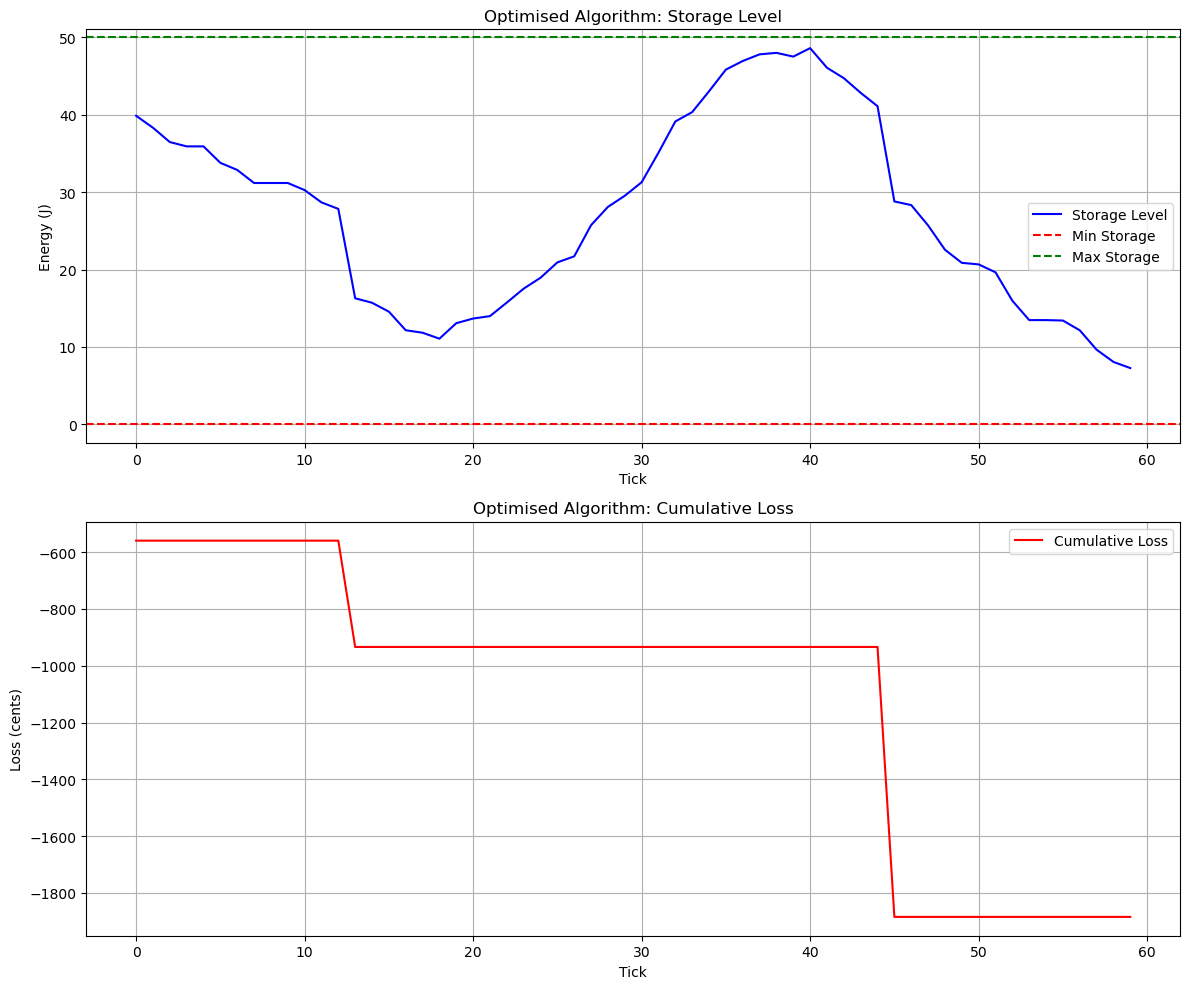

Final loss: 1884.15 cents

Actions breakdown:
- partial_import_for_deferable: 3
- used_storage: 55
- solar_charging: 29


In [95]:
def run_optimized_algorithm(df, defer_df):
    """Optimized algorithm with maximum discharge rate of 10J per tick"""
    MAX_DISCHARGE_RATE = 10  # Maximum energy that can be used per tick
    storage = [MAX_STORAGE]
    actions = []
    profit = 0
    profit_over_time = []

    for i in range(len(df)):
        tick = df['tick'][i]
        sell_price = df.iloc[i]['sell_price']
        buy_price = sell_price * 0.5
        demand = df['demand'][i]
        sun = df['sun'][i]
        current_storage = storage[-1]

        # 1. Use solar energy (free energy)
        if sun > 0:
            solar_energy = sun * 0.01 * 5
            current_storage = min(current_storage + solar_energy, MAX_STORAGE)
            actions.append('solar_charging')

        # 2. Handle immediate demand with rate limiting
        if demand > 0:
            discharge_possible = min(current_storage, MAX_DISCHARGE_RATE)
            if discharge_possible >= demand:
                current_storage -= demand
                actions.append('used_storage')
            else:
                # Use what we can from storage (up to rate limit)
                current_storage -= discharge_possible
                # Buy the rest
                remaining_demand = demand - discharge_possible
                profit -= remaining_demand * buy_price
                actions.append('partial_import')

        # 3. Handle deferable demands with rate limiting
        defer_now = defer_df[(defer_df['start'] <= tick) & (defer_df['end'] >= tick)]
        if not defer_now.empty:
            for _, row in defer_now.iterrows():
                if tick == row['start']:
                    energy_needed = row['energy']
                    discharge_possible = min(current_storage, MAX_DISCHARGE_RATE)
                    if discharge_possible >= energy_needed:
                        current_storage -= energy_needed
                        actions.append('used_storage_for_deferable')
                    else:
                        # Use what we can from storage
                        current_storage -= discharge_possible
                        # Buy the rest
                        remaining_energy = energy_needed - discharge_possible
                        profit -= remaining_energy * buy_price
                        actions.append('partial_import_for_deferable')

        # 4. Buy if storage is critically low (with rate limit)
        if current_storage < MIN_STORAGE:
            buy_amt = min(MAX_STORAGE - current_storage, MAX_DISCHARGE_RATE)
            profit -= buy_amt * buy_price
            current_storage += buy_amt
            actions.append('rate_limited_buy')

        current_storage = max(MIN_STORAGE, min(current_storage, MAX_STORAGE))
        storage.append(current_storage)
        profit_over_time.append(profit)

    return storage[1:], profit_over_time, actions

# Fetch and prepare data
df, defer_df = fetch_server_data()
df = add_sun_data(df)

# Run algorithm
storage, profit_over_time, actions = run_optimized_algorithm(df, defer_df)

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Storage plot
ax1.plot(df['tick'], storage, label='Storage Level', color='blue')
ax1.axhline(y=MIN_STORAGE, color='r', linestyle='--', label='Min Storage')
ax1.axhline(y=MAX_STORAGE, color='g', linestyle='--', label='Max Storage')
ax1.set_title('Optimised Algorithm: Storage Level')
ax1.set_xlabel('Tick')
ax1.set_ylabel('Energy (J)')
ax1.legend()
ax1.grid(True)

# Loss plot
ax2.plot(df['tick'], profit_over_time, label='Cumulative Loss', color='red')
ax2.set_title('Optimised Algorithm: Cumulative Loss')
ax2.set_xlabel('Tick')
ax2.set_ylabel('Loss (cents)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Final loss: {-profit_over_time[-1]:.2f} cents")
print(f"\nActions breakdown:")
for action in set(actions):
    print(f"- {action}: {actions.count(action)}")


Energy Flow Statistics:
Average charge rate: 1.28J/tick
Average discharge rate: 1.85J/tick
Max charge rate: 5.00J/tick
Max discharge rate: 10.00J/tick


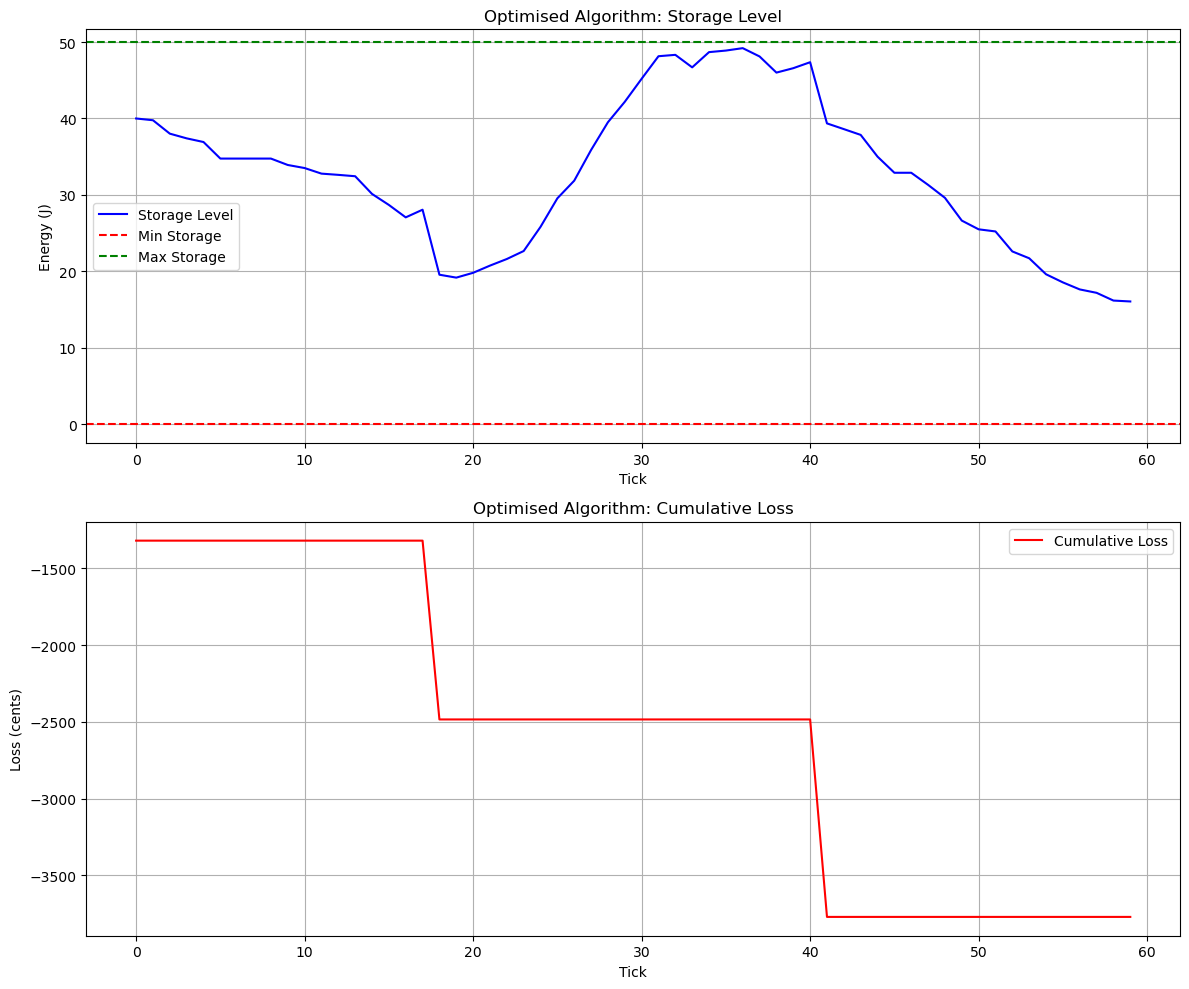

Final loss: 3770.01 cents

Actions breakdown:
- used_storage_4.0J: 1
- used_storage_2.4J: 2
- used_storage_2.7J: 1
- used_storage_1.1J: 3
- used_storage_1.8J: 3
- used_storage_1.2J: 1
- used_storage_1.9J: 3
- used_storage_2.0J: 2
- solar_charging_0.8J: 1
- used_storage_deferable_8.1J: 1
- used_storage_1.6J: 1
- solar_charging_4.5J: 1
- used_storage_1.3J: 1
- solar_charging_3.3J: 2
- solar_charging_4.0J: 1
- used_storage_2.1J: 3
- used_storage_3.3J: 3
- solar_charging_2.9J: 2
- solar_charging_0.5J: 2
- used_storage_2.3J: 3
- used_storage_0.5J: 1
- used_storage_0.7J: 2
- solar_charging_1.0J: 2
- solar_charging_1.5J: 2
- solar_charging_5.0J: 2
- import_deferable_remaining_27.1J: 1
- used_storage_2.2J: 4
- solar_charging_3.7J: 1
- solar_charging_1.3J: 1
- solar_charging_4.3J: 1
- used_storage_0.4J: 2
- solar_charging_4.8J: 3
- used_storage_0.2J: 3
- used_storage_0.8J: 3
- used_storage_0.3J: 1
- used_storage_0.6J: 2
- solar_charging_1.9J: 2
- used_storage_1.7J: 3
- solar_charging_1.7J: 1
- 

In [98]:
def run_optimized_algorithm(df, defer_df):
    """Optimized algorithm with strict rate limiting and energy tracking"""
    MAX_DISCHARGE_RATE = 10  # Maximum energy output per tick
    MAX_CHARGE_RATE = 10    # Maximum energy input per tick
    storage = [MAX_STORAGE]
    actions = []
    profit = 0
    profit_over_time = []
    
    # Add debug tracking
    energy_flows = []

    for i in range(len(df)):
        tick = df['tick'][i]
        sell_price = df.iloc[i]['sell_price']
        buy_price = sell_price * 0.5
        demand = df['demand'][i]
        sun = df['sun'][i]
        current_storage = storage[-1]
        
        # Track energy movement this tick
        charge_this_tick = 0
        discharge_this_tick = 0
        
        # 1. Handle solar with rate limiting
        if sun > 0:
            desired_solar = sun * 0.01 * 5
            remaining_charge_rate = MAX_CHARGE_RATE - charge_this_tick
            possible_solar = min(desired_solar, remaining_charge_rate)
            actual_solar = min(possible_solar, MAX_STORAGE - current_storage)
            
            current_storage += actual_solar
            charge_this_tick += actual_solar
            if actual_solar > 0:
                actions.append(f'solar_charging_{actual_solar:.1f}J')

        # 2. Handle immediate demand with strict rate limiting
        if demand > 0:
            remaining_discharge = MAX_DISCHARGE_RATE - discharge_this_tick
            discharge_possible = min(current_storage, remaining_discharge, demand)
            
            if discharge_possible > 0:
                current_storage -= discharge_possible
                discharge_this_tick += discharge_possible
                actions.append(f'used_storage_{discharge_possible:.1f}J')
            
            if discharge_possible < demand:
                remaining_demand = demand - discharge_possible
                profit -= remaining_demand * buy_price
                actions.append(f'import_{remaining_demand:.1f}J')

        # 3. Handle deferables with remaining rate capacity
        defer_now = defer_df[(defer_df['start'] <= tick) & (defer_df['end'] >= tick)]
        if not defer_now.empty:
            for _, row in defer_now.iterrows():
                if tick == row['start']:
                    remaining_discharge = MAX_DISCHARGE_RATE - discharge_this_tick
                    if remaining_discharge <= 0:
                        profit -= row['energy'] * buy_price
                        actions.append(f'import_deferable_{row["energy"]:.1f}J')
                        continue
                    
                    discharge_possible = min(current_storage, remaining_discharge, row['energy'])
                    if discharge_possible > 0:
                        current_storage -= discharge_possible
                        discharge_this_tick += discharge_possible
                        actions.append(f'used_storage_deferable_{discharge_possible:.1f}J')
                    
                    if discharge_possible < row['energy']:
                        remaining_energy = row['energy'] - discharge_possible
                        profit -= remaining_energy * buy_price
                        actions.append(f'import_deferable_remaining_{remaining_energy:.1f}J')

        # 4. Emergency buy with rate limiting
        if current_storage < MIN_STORAGE:
            remaining_charge = MAX_CHARGE_RATE - charge_this_tick
            buy_amt = min(MAX_STORAGE - current_storage, remaining_charge)
            if buy_amt > 0:
                profit -= buy_amt * buy_price
                current_storage += buy_amt
                charge_this_tick += buy_amt
                actions.append(f'emergency_buy_{buy_amt:.1f}J')

        # Record energy flows for debugging
        energy_flows.append({
            'tick': tick,
            'charge': charge_this_tick,
            'discharge': discharge_this_tick,
            'storage': current_storage
        })

        current_storage = max(MIN_STORAGE, min(current_storage, MAX_STORAGE))
        storage.append(current_storage)
        profit_over_time.append(profit)

    # Print energy flow statistics
    print("\nEnergy Flow Statistics:")
    flows_df = pd.DataFrame(energy_flows)
    print(f"Average charge rate: {flows_df['charge'].mean():.2f}J/tick")
    print(f"Average discharge rate: {flows_df['discharge'].mean():.2f}J/tick")
    print(f"Max charge rate: {flows_df['charge'].max():.2f}J/tick")
    print(f"Max discharge rate: {flows_df['discharge'].max():.2f}J/tick")

    return storage[1:], profit_over_time, actions

# Fetch and prepare data
df, defer_df = fetch_server_data()
df = add_sun_data(df)

# Run algorithm
storage, profit_over_time, actions = run_optimized_algorithm(df, defer_df)

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Storage plot
ax1.plot(df['tick'], storage, label='Storage Level', color='blue')
ax1.axhline(y=MIN_STORAGE, color='r', linestyle='--', label='Min Storage')
ax1.axhline(y=MAX_STORAGE, color='g', linestyle='--', label='Max Storage')
ax1.set_title('Optimised Algorithm: Storage Level')
ax1.set_xlabel('Tick')
ax1.set_ylabel('Energy (J)')
ax1.legend()
ax1.grid(True)

# Loss plot
ax2.plot(df['tick'], profit_over_time, label='Cumulative Loss', color='red')
ax2.set_title('Optimised Algorithm: Cumulative Loss')
ax2.set_xlabel('Tick')
ax2.set_ylabel('Loss (cents)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Final loss: {-profit_over_time[-1]:.2f} cents")
print(f"\nActions breakdown:")
for action in set(actions):
    print(f"- {action}: {actions.count(action)}")


Energy Flow Statistics:
Average charge rate: 1.11J/tick
Average discharge rate: 1.94J/tick
Max charge rate: 4.75J/tick
Max discharge rate: 10.00J/tick


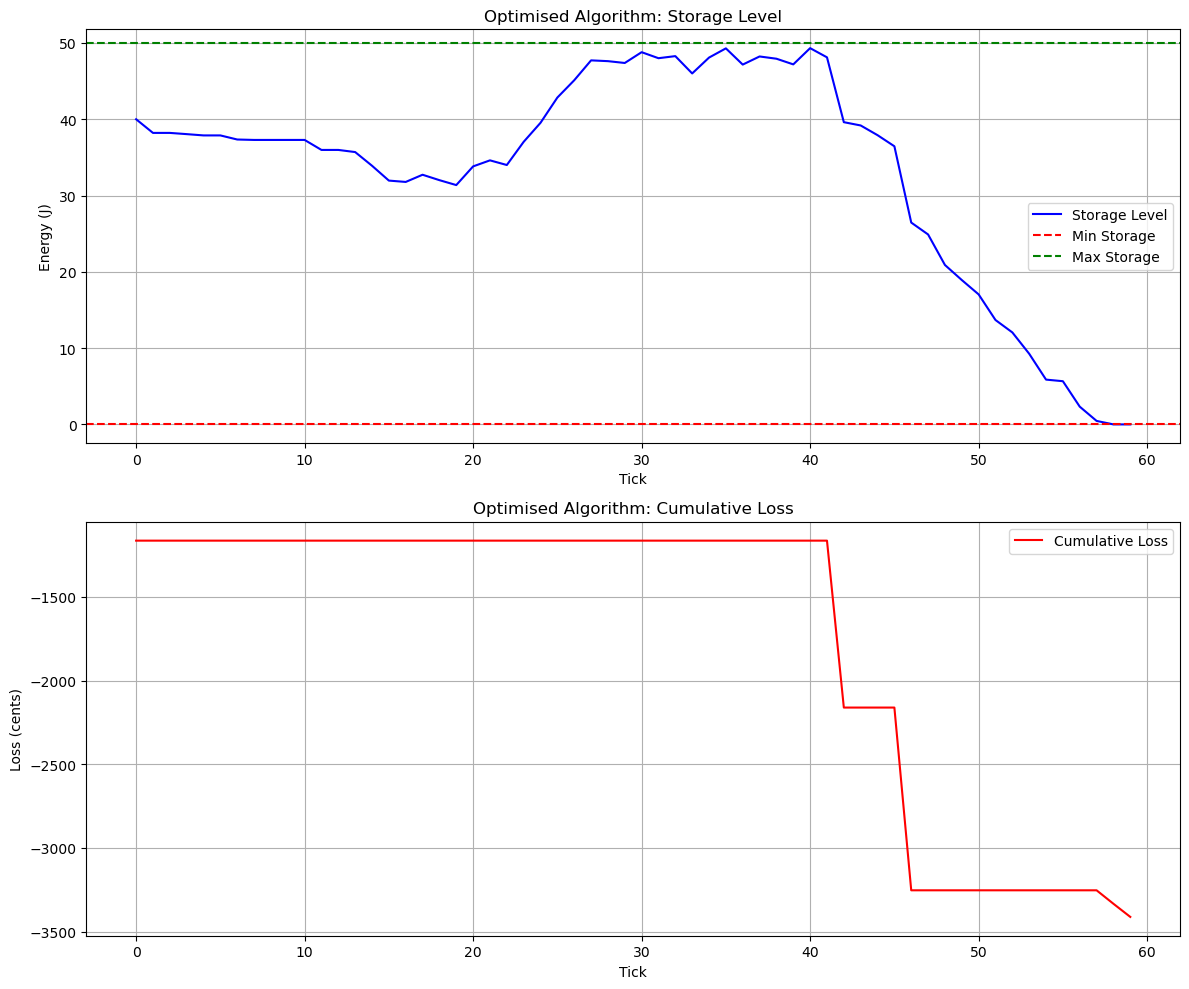

Final loss: 3412.76 cents

Actions breakdown:
- used_storage_4.0J: 2
- used_storage_2.4J: 1
- used_storage_1.8J: 4
- used_storage_deferable_8.4J: 1
- used_storage_1.9J: 5
- used_storage_1.2J: 1
- used_storage_2.0J: 2
- used_storage_1.6J: 3
- solar_charging_4.5J: 1
- used_storage_1.3J: 2
- used_storage_deferable_8.7J: 1
- solar_charging_3.3J: 1
- solar_charging_4.0J: 2
- used_storage_2.1J: 3
- used_storage_3.3J: 1
- solar_charging_2.8J: 1
- import_deferable_remaining_30.2J: 1
- used_storage_1.5J: 2
- solar_charging_2.9J: 1
- solar_charging_0.5J: 2
- used_storage_2.3J: 1
- used_storage_0.5J: 2
- used_storage_2.8J: 3
- import_2.0J: 1
- used_storage_0.7J: 3
- solar_charging_1.0J: 2
- solar_charging_1.5J: 2
- used_storage_2.2J: 1
- solar_charging_3.7J: 1
- solar_charging_4.3J: 1
- solar_charging_2.6J: 1
- solar_charging_1.2J: 1
- solar_charging_1.8J: 1
- import_deferable_remaining_22.3J: 1
- solar_charging_4.8J: 1
- used_storage_0.2J: 3
- used_storage_0.3J: 2
- solar_charging_2.3J: 1
- sola

In [101]:
def run_price_optimized_algorithm(df, defer_df):
    """Price-aware optimized algorithm with rate limiting and predictive solar use"""
    MAX_DISCHARGE_RATE = 10
    MAX_CHARGE_RATE = 10
    storage = [MAX_STORAGE]
    actions = []
    profit = 0
    profit_over_time = []
    energy_flows = []
    
    # Calculate price thresholds
    buy_threshold = df['buy_price'].quantile(0.25)  # Buy when price in lowest 25%
    sell_threshold = df['sell_price'].quantile(0.75) # Sell when price in highest 25%
    
    # Pre-process deferable demands
    deferable_schedule = {}  # Will store {tick: [(energy_needed, end_tick)]}
    for _, row in defer_df.iterrows():
        window_prices = df.loc[row['start']:row['end'], 'buy_price']
        best_ticks = window_prices.nsmallest(3).index  # Get 3 best price points
        energy_per_tick = row['energy'] / len(best_ticks)
        for tick in best_ticks:
            if tick not in deferable_schedule:
                deferable_schedule[tick] = []
            deferable_schedule[tick].append((energy_per_tick, row['end']))

    for i in range(len(df)):
        tick = df['tick'][i]
        sell_price = df.iloc[i]['sell_price']
        buy_price = sell_price * 0.5
        demand = df['demand'][i]
        sun = df['sun'][i]
        current_storage = storage[-1]
        
        charge_this_tick = 0
        discharge_this_tick = 0

        # 1. Predictive solar handling
        if tick < SUNRISE and current_storage > MIN_STORAGE + 10:
            # Make room for upcoming solar energy
            space_needed = 10  # Reserve space for solar
            discharge_possible = min(MAX_DISCHARGE_RATE, current_storage - MIN_STORAGE - 10)
            if discharge_possible > 0:
                current_storage -= discharge_possible
                discharge_this_tick += discharge_possible
                actions.append(f'pre_solar_discharge_{discharge_possible:.1f}J')
        
        if sun > 0:
            desired_solar = sun * 0.01 * 5
            remaining_charge_rate = MAX_CHARGE_RATE - charge_this_tick
            possible_solar = min(desired_solar, remaining_charge_rate)
            actual_solar = min(possible_solar, MAX_STORAGE - current_storage)
            
            current_storage += actual_solar
            charge_this_tick += actual_solar
            if actual_solar > 0:
                actions.append(f'solar_charging_{actual_solar:.1f}J')

        # 2. Price-based storage management
        if buy_price <= buy_threshold and current_storage < MAX_STORAGE:
            remaining_charge = MAX_CHARGE_RATE - charge_this_tick
            buy_amt = min(MAX_STORAGE - current_storage, remaining_charge)
            if buy_amt > 0:
                current_storage += buy_amt
                charge_this_tick += buy_amt
                profit -= buy_amt * buy_price
                actions.append(f'cheap_buy_{buy_amt:.1f}J')
        
        # 3. Handle immediate demand
        if demand > 0:
            remaining_discharge = MAX_DISCHARGE_RATE - discharge_this_tick
            discharge_possible = min(current_storage, remaining_discharge, demand)
            
            if discharge_possible > 0:
                current_storage -= discharge_possible
                discharge_this_tick += discharge_possible
                actions.append(f'used_storage_{discharge_possible:.1f}J')
            
            if discharge_possible < demand:
                remaining_demand = demand - discharge_possible
                profit -= remaining_demand * buy_price
                actions.append(f'import_{remaining_demand:.1f}J')

        # 4. Handle scheduled deferables
        if tick in deferable_schedule:
            for energy_needed, end_tick in deferable_schedule[tick]:
                remaining_discharge = MAX_DISCHARGE_RATE - discharge_this_tick
                if remaining_discharge <= 0:
                    profit -= energy_needed * buy_price
                    actions.append(f'import_deferable_{energy_needed:.1f}J')
                    continue
                
                discharge_possible = min(current_storage, remaining_discharge, energy_needed)
                if discharge_possible > 0:
                    current_storage -= discharge_possible
                    discharge_this_tick += discharge_possible
                    actions.append(f'used_storage_deferable_{discharge_possible:.1f}J')
                
                if discharge_possible < energy_needed:
                    remaining_energy = energy_needed - discharge_possible
                    profit -= remaining_energy * buy_price
                    actions.append(f'import_deferable_remaining_{remaining_energy:.1f}J')

        # 5. Opportunistic selling at high prices
        if sell_price >= sell_threshold and current_storage > MIN_STORAGE + 10:
            remaining_discharge = MAX_DISCHARGE_RATE - discharge_this_tick
            sell_amt = min(current_storage - MIN_STORAGE - 10, remaining_discharge)
            if sell_amt > 0:
                current_storage -= sell_amt
                discharge_this_tick += sell_amt
                profit += sell_amt * sell_price
                actions.append(f'high_price_sell_{sell_amt:.1f}J')

        # Record energy flows
        energy_flows.append({
            'tick': tick,
            'charge': charge_this_tick,
            'discharge': discharge_this_tick,
            'storage': current_storage,
            'buy_price': buy_price,
            'sell_price': sell_price
        })

        current_storage = max(MIN_STORAGE, min(current_storage, MAX_STORAGE))
        storage.append(current_storage)
        profit_over_time.append(profit)

    # Print statistics
    flows_df = pd.DataFrame(energy_flows)
    print("\nEnergy Flow Statistics:")
    print(f"Average charge rate: {flows_df['charge'].mean():.2f}J/tick")
    print(f"Average discharge rate: {flows_df['discharge'].mean():.2f}J/tick")
    print(f"Max charge rate: {flows_df['charge'].max():.2f}J/tick")
    print(f"Max discharge rate: {flows_df['discharge'].max():.2f}J/tick")
    print(f"Average buy price: {flows_df['buy_price'].mean():.2f} cents/J")
    print(f"Average sell price: {flows_df['sell_price'].mean():.2f} cents/J")

    return storage[1:], profit_over_time, actions

# Fetch and prepare data
df, defer_df = fetch_server_data()
df = add_sun_data(df)

# Run algorithm
storage, profit_over_time, actions = run_optimized_algorithm(df, defer_df)

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Storage plot
ax1.plot(df['tick'], storage, label='Storage Level', color='blue')
ax1.axhline(y=MIN_STORAGE, color='r', linestyle='--', label='Min Storage')
ax1.axhline(y=MAX_STORAGE, color='g', linestyle='--', label='Max Storage')
ax1.set_title('Optimised Algorithm: Storage Level')
ax1.set_xlabel('Tick')
ax1.set_ylabel('Energy (J)')
ax1.legend()
ax1.grid(True)

# Loss plot
ax2.plot(df['tick'], profit_over_time, label='Cumulative Loss', color='red')
ax2.set_title('Optimised Algorithm: Cumulative Loss')
ax2.set_xlabel('Tick')
ax2.set_ylabel('Loss (cents)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Final loss: {-profit_over_time[-1]:.2f} cents")
print(f"\nActions breakdown:")
for action in set(actions):
    print(f"- {action}: {actions.count(action)}")